# 傅里叶变换应用

## 学习目的

- 学会看频谱，时域中的形状和纹理对应频谱上的什么位置，频谱上的点和线对应时域中的什么物体
- 学会将时域的相关运算，通过傅里叶变换转成频域的点乘运算，然后通过反变换得结果
- 了解FFT的实现细节，为什么乘$\frac{1}{MN}$是在反变换时进行，以及算法对图片大小的限制

## 常数、单位冲激与sinc函数

当图中只有一条竖线时，图片在水平方向的灰度集中于width=128，表现在频谱上就是水平方向的频率分布非常分散，各个频率对应的幅值都一样，对应常数255\*16；图片在垂直方向上，height=0~255灰度值都为255，即灰度非常分散，对应到频谱上就是垂直方向上的频率分布非常集中，集中于频率为0处，对应单位冲激函数。

In [1]:
import numpy as np
import scipy.misc as misc
import skimage.draw as draw
import matplotlib.pyplot as plt

In [2]:
def show_dft(image):
    fft=np.fft.fft2(image)
    fft=np.fft.fftshift(fft)
    
    plt.figure(figsize=(8,16))
    plt.subplot(1,3,1)
    plt.imshow(image,'gray',label='image')
    plt.subplot(1,3,2)
    plt.imshow(fft.real,'gray',label='real')
    plt.subplot(1,3,3)
    plt.imshow(np.abs(fft),'gray',label='power')

In [3]:
def assert_real(fft):
    assert(np.abs(fft.imag)<1e-7).all()

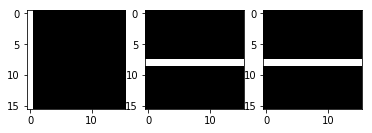

In [4]:
f=np.zeros((16,16),dtype=int)
f[:,0]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [5]:
fft_y[8,:]

array([4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j,
       4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j,
       4080.+0.j, 4080.+0.j, 4080.+0.j, 4080.+0.j])

实数的频谱总是共轭对称的，即fft_y[7,0]与fft_y[9,16]是一对共轭复数。如下图所示，当输入是位于原点的对称线段时，对应一维门限函数，频谱在水平方向上为常数，垂直方向上为sinc函数。需要注意的是输入图片的原点在左上角，而傅里叶变换处理的输入和输出都是周期的，因此f[15:17,0]=255对应于f[-2:0,0]=255。

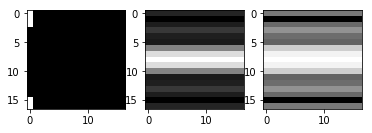

In [6]:
f=np.zeros((17,17),dtype=int)
f[0:3,0]=255
f[15:17,0]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [7]:
fft_y[8,:]

array([1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j,
       1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j,
       1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j, 1275.+0.j])

In [8]:
fft_y[7,:]

array([1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j])

In [9]:
fft_y[9,:]

array([1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j, 1107.45538478+0.j,
       1107.45538478+0.j, 1107.45538478+0.j])

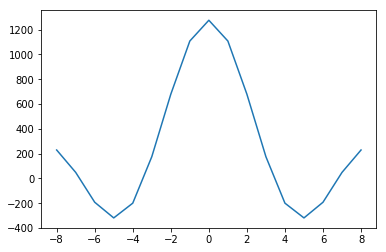

In [10]:
x=np.linspace(0,16,17)-8
plt.plot(x,fft_y[:,0].real)

## 傅里叶变换的性质

### 傅里叶变换对的方向性：偶函数及其频谱，不管哪个在时域哪个在频域，始终是一对

单位脉冲函数的傅里叶正变换是常数，单位脉冲函数的反变换也是常数；常数的正变换是单位脉冲函数，常数的反变换也是单位脉冲函数；门限函数的正变换是sinc函数，反变换还是sinc函数吗？sinc函数的正反变换呢？傅里叶变换对有方向吗？哪些函数的傅里叶正变换和反变换的结果一样？

sinc函数的正反变换**确实都是**门限函数，门限函数的正反变换**确实都是**sinc函数，但是不是所有的函数都是这样，否则还要反变换干什么呢？

两次**连续傅里叶正变换**等于原函数取反，即f(t)变为f(-t)。偶函数的傅里叶正变换和反变换结果一样。证明：
$$
\begin{align}
F\{f(t)\} & =\int_{-\infty}^{+\infty}f(t)e^{-j2\pi \mu t}dt\\
& =\int_{+\infty}^{-\infty}f(-t)e^{j2\pi \mu t}d(-t)\\
& =\int_{-\infty}^{+\infty}f(-t)e^{j2\pi \mu t}dt\\
& =\int_{-\infty}^{+\infty}f(t)e^{j2\pi \mu t}dt\\
& =F^{-1}\{f(t)\}
\end{align}
$$
而根据上述连续函数傅里叶变换公式在一个周期M\*N内离散化，二维离散变换公式如下
$$
\begin{align}
F(\frac{u}{M},\frac{v}{N})& =\sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x,y)e^{-j2\pi(\frac{u}{M}x+\frac{v}{N}y)}\\
f(x,y)& =\frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(\frac{u}{M},\frac{v}{N})e^{j2\pi \frac{u}{M}x+\frac{v}{N}y}
\end{align}
$$
由于$\Delta u =\frac{1}{M}$,$\Delta v = \frac{1}{N}$，所以反变换的前面多乘了$\frac{1}{MN}$。因此两次**离散傅里叶正变换**后，$f(x,y)$变成了$MNf(-x,-y)$。

需要注意的是傅里叶变换公式的另一版本，使用的自变量是角频率$\omega$，与傅里叶变换的泛化版*拉普拉斯变换*在形式上一致：
$$
\begin{align}
F(s) & =\int_{-\infty}^{+\infty}f(t)e^{st}dt \\
f(t) & =\frac{1}{2\pi}\int_{-\infty}^{+\infty}F(s)e^{st}ds \\
s & =jw
\end{align}
$$
上述正变换公式得到的频谱，与频率版的结果被横向拉伸后一致。原因是$\omega=2\pi f$，频率$f$变化一个单位长度，角频率$\omega$已经变换了$2\pi$个单位长度。使用上述公式，$f(t)$两次正变换后得到$2\pi f(-t)$。数字图像处理领域以中间的离散傅里叶变换公式为准，对应频率版连续傅里叶变换公式。

### 离散傅里叶变换的周期性：处理的输入和输出都是定义在$(-\infty,+\infty)$上的周期信号

傅里叶变换处理的输入和输出都是定义在$(-\infty,+\infty)$上的函数。当我们谈论数字图像的傅里叶变换时，谈论的是这样一个过程。

物理世界中连续的图像，加门限函数，得到有限长宽的连续图像信号。没有**有限持续时间的函数**是带限的，也没有**有限持续时间的函数**是周期的，即该图像信号对应的频谱在$(-\infty,+\infty)$上都有连续值。如果对其做周期延拓，使之成为连续的周期函数，则其对应频谱是无限离散的。对该周期且连续的图像信号进行采样获得数字图像，其频谱等于原来周期且连续的图像信号对应的离散谱，无穷个$\frac{1}{T}$平移叠加。并且以$\frac{1}{T}$为周期。T为采样间隔。

当采样之前的连续周期图像信号是带限，即可以通过有限正余弦信号完美重现，此时对频谱加个门限信号，取出一个周期，做傅里叶反变换，即可完美重构采样之前的连续周期图像信号。但是现实世界中的连续图像信号通常不是带限的，因此引入了混淆。考虑临界情况，连续周期图像信号是带限的，截止频率等于$ \pm\frac{1}{2T}$,那么通过反变换将可以完美复原连续周期图像信号，也即完美恢复了采样之后的离散周期图像信号。

当我们拿到一张数字图像及其傅里叶谱，谁知道原信号是不是截止频率在$ \pm\frac{1}{2T}$以内呢？如果不在，那么对频谱做傅里叶反变换将得到与现实世界相比存在失真的连续周期图像。至于和那张数字图像相比，一个周期内一定是一模一样的。

### 当输入是**实函数**和**偶函数**，即$f(x,y)=f(-x,-y)$时,其频谱为**实函数**和**偶函数**。

由共轭对称，即$F(u,v)=F^*(-u,-v)$,且$F(u,v)$是实数，很容易得到$F(u,v)=F(-u,-v)$。

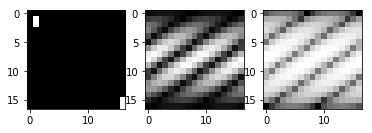

In [11]:
f=np.zeros((17,17),dtype=int)
f[1:3,1]=255
f[15:17,16]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [12]:
np.sum(fft_y.imag==0)==17*17

True

当图片大小为偶数时，图中只有中心位于图片中心，即$(\frac{W}{2},\frac{H}{2})$，且中心对称的物体，这样的图片是偶函数，对应频谱是实数。

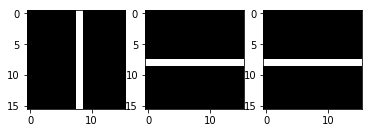

In [13]:
f=np.zeros((16,16),dtype=int)
f[:,8]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [14]:
fft_y[8,:]

array([ 4080.+0.j, -4080.+0.j,  4080.+0.j, -4080.+0.j,  4080.+0.j,
       -4080.+0.j,  4080.+0.j, -4080.+0.j,  4080.+0.j, -4080.+0.j,
        4080.+0.j, -4080.+0.j,  4080.+0.j, -4080.+0.j,  4080.+0.j,
       -4080.+0.j])

当图片大小为奇数时，虽然图中有准确的中心$(\frac{W-1}{2},\frac{H-1}{2})$,并且图片中心对称，但是这样的图片不是奇函数也不是偶函数，对应复数频谱。

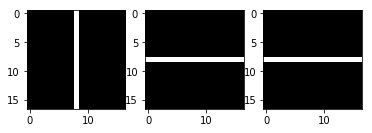

In [15]:
f=np.zeros((17,17),dtype=int)
f[:,8]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [16]:
fft_y[8,:]

array([  399.98333827-4316.50765424j, -1186.32906196+4169.51416315j,
        1932.27577229-3880.53286802j, -2612.4211487 +3459.40468026j,
        3203.60365615-2920.47061521j, -3685.69128339+2282.08342607j,
        4042.26711447-1565.98262292j, -4261.18838713 +796.55415973j,
        4335.           +0.j        , -4261.18838713 -796.55415973j,
        4042.26711447+1565.98262292j, -3685.69128339-2282.08342607j,
        3203.60365615+2920.47061521j, -2612.4211487 -3459.40468026j,
        1932.27577229+3880.53286802j, -1186.32906196-4169.51416315j,
         399.98333827+4316.50765424j])

### 当输入是**实函数**和**奇函数**，即f(x,y)=-f(-x,-y)时,其频谱为**虚函数**和**奇函数**。

由共轭对称，即$F(u,v)=F^*(-u,-v)$,且$F(u,v)$是虚数，很容易得到$F(u,v)=-F(-u,-v)$

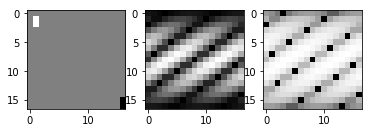

In [17]:
f=np.zeros((17,17),dtype=int)
f[1:3,1]=127
f[15:17,16]=-127
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [18]:
np.sum(fft_y.real==0)==17*17

True

### 傅里叶变换的平移特性

#### 原图的平移

将图片向左平移2个像素，图片不再是偶函数，对应复数频谱。频谱的幅值不变，相角改变$-2\pi(\frac{x_{0}}{W}u+\frac{y_0}{H}v)$，即不同频率的正弦波相角改变不一样。图中频谱大小为16*16，即偶数，最左边的一列恒等于自身，可以是任意值，找不到另外一列与其共轭对称；中间一列是垂直频率为0的列，可以是任意值；其余列共轭对称。

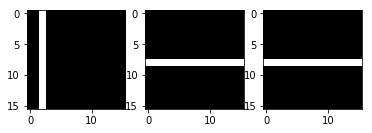

In [19]:
f=np.zeros((16,16),dtype=int)
f[:,2]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
log_fft_y=np.log(1+np.abs(fft_y))
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_y),'gray')
plt.subplot(1,3,3)
plt.imshow(log_fft_y,'gray')

In [20]:
fft_y[8,:]

array([ 4080.           +0.j        ,  2884.99566724-2884.99566724j,
           0.        -4080.j        , -2884.99566724-2884.99566724j,
       -4080.           +0.j        , -2884.99566724+2884.99566724j,
           0.        +4080.j        ,  2884.99566724+2884.99566724j,
        4080.           +0.j        ,  2884.99566724-2884.99566724j,
           0.        -4080.j        , -2884.99566724-2884.99566724j,
       -4080.           +0.j        , -2884.99566724+2884.99566724j,
           0.        +4080.j        ,  2884.99566724+2884.99566724j])

In [21]:
np.abs(fft_y)[8,:]

array([4080., 4080., 4080., 4080., 4080., 4080., 4080., 4080., 4080.,
       4080., 4080., 4080., 4080., 4080., 4080., 4080.])

In [22]:
np.angle(fft_y)[8,:]

array([ 0.        , -0.78539816, -1.57079633, -2.35619449,  3.14159265,
        2.35619449,  1.57079633,  0.78539816,  0.        , -0.78539816,
       -1.57079633, -2.35619449,  3.14159265,  2.35619449,  1.57079633,
        0.78539816])

#### 频谱图的平移

将频谱向下平移2个像素，去中心化后，如下图2所示。反变换后得到原图，可发现原来的实数图片变成了复数，相位的变化是$2\pi(\frac{u_{0}}{W}x+\frac{v_0}{H}y)$。

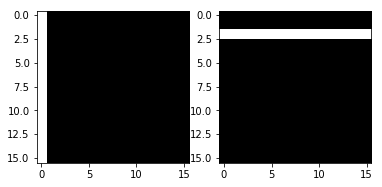

In [23]:
fft_y=np.zeros((16,16),dtype=int)
fft_y[2,:]=4080
f=np.fft.ifft2(fft_y)
plt.subplot(1,2,1)
plt.imshow(np.abs(f),'gray')
plt.subplot(1,2,2)
plt.imshow(fft_y,'gray')

In [24]:
f[:,0]

array([ 255.         +0.j       ,  180.3122292+180.3122292j,
          0.       +255.j       , -180.3122292+180.3122292j,
       -255.         +0.j       , -180.3122292-180.3122292j,
          0.       -255.j       ,  180.3122292-180.3122292j,
        255.         +0.j       ,  180.3122292+180.3122292j,
          0.       +255.j       , -180.3122292+180.3122292j,
       -255.         +0.j       , -180.3122292-180.3122292j,
          0.       -255.j       ,  180.3122292-180.3122292j])

当频谱图以左上为原点，平移至中央，对应原图如下所示。即如果将原图先变成$f(x,y)(-1)^{x+y}$，做傅里叶变换将得到中心化后的谱。

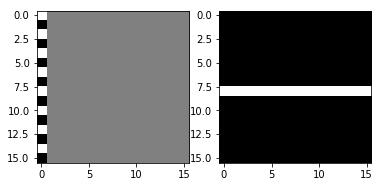

In [25]:
fft_y=np.zeros((16,16),dtype=int)
fft_y[8,:]=4080
f=np.fft.ifft2(fft_y)
plt.subplot(1,2,1)
plt.imshow(f.real,'gray')
plt.subplot(1,2,2)
plt.imshow(fft_y,'gray')

In [26]:
f[:,0]

array([ 255.+0.j, -255.+0.j,  255.+0.j, -255.+0.j,  255.+0.j, -255.+0.j,
        255.+0.j, -255.+0.j,  255.+0.j, -255.+0.j,  255.+0.j, -255.+0.j,
        255.+0.j, -255.+0.j,  255.+0.j, -255.+0.j])

### 傅里叶变换的旋转特性

将图片旋转45°，其频谱也随之旋转同样角度。下图中图片大小是15\*15的，对应实数谱，对角线上取值15\*255=3825。严格地说，该反变化包含了舍入误差。圆是中心对称的，怎么转都不变，可推测其频谱也是怎么转都不变，即中心对称的。

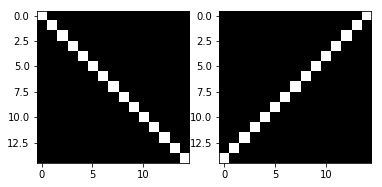

In [27]:
f=np.diag(255*np.ones(15,dtype=int))
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
plt.subplot(1,2,1)
plt.imshow(f,'gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(fft_y),'gray')

In [28]:
np.diag(np.rot90(fft_y)).real

array([3825., 3825., 3825., 3825., 3825., 3825., 3825., 3825., 3825.,
       3825., 3825., 3825., 3825., 3825., 3825.])

需要注意的是在旋转过程中线段的长度改变了。假如线段的长度不变，频谱图中能量将会出现扩散。直观理解上，傅里叶变换处理的输入是周期的，旋转不变性指的是对整个输入信号旋转，而不是对输入信号的一个周期旋转。整个周期信号旋转45°后，在一个周期内的样子就是对角线，长了$\sqrt{2}$倍。另外值得注意的是虽然长度变长了，但是仍旧是15个像素，因此其时域的平均功率没变，依旧是$15*255^2/(15*15)=4335$。而频谱的幅值也没变，频域能量为$(3825/(15*15))^2*15=4335$，依旧符合帕斯瓦尔定理（时频能量守恒）。说明：numpy或其它工具包在计算fft正变换得频谱时，没乘$\frac{1}{MN}$，而选择在反变换的时候乘$\frac{1}{MN}$，在计算能量守恒的时候自己要把这一操作加上。让人难办的是如果旋转角度是30°，如何画出这条直线？在旋转的问题上，涉及到亚像素精度，细节上不必太较真，整体看起来就是图片旋转了，频谱也旋转了。

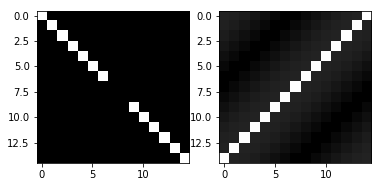

In [29]:
f=np.diag(255*np.ones(15,dtype=int))
f[8,8]=0
f[7,7]=0
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
plt.subplot(1,2,1)
plt.imshow(f,'gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(fft_y),'gray')

### 傅里叶变换的线性特性 $F(af_1(x,y)+bf_2(x,y))=aF(f_1(x,y))+bF(f_2(x,y))$

如何将两条线的频谱分开，从而通过傅里叶反变换，分别得到图中的两条线？

因为两条线都是偶函数，即通过周期延拓，图案以原点为中心对称，所以频谱一定是实数。其中一条线可以通过另一条线平移得到，设$f_1(x,y)=128*g(x,y)$，$f_2(x,y)=255*g(x-8,y-8)$，$128F(g(x,y))+255*(-1)^{x+y}F(g(x,y))=F(pic)$，可求得$F(g(x,y))$，从而实现分割。然而将频谱表示成两张谱的相加有无穷种，每一种都可以反变换得到一张图，究竟哪两张图是我们需要的分割？事实上这是一个错误的问题，本来目标在时域就很好分割，搞到频域反而复杂。使用傅里叶变换旨在处理时域难以分割，而放到频域，目标和背景对应的频谱相对独立，易于分开的问题。

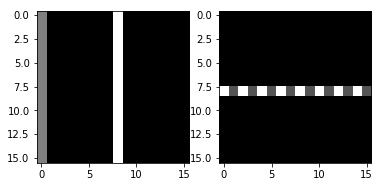

In [30]:
f=np.zeros((16,16),dtype=int)
f[:,0]=128
f[:,8]=255
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
plt.subplot(1,2,1)
plt.imshow(f,'gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(fft_y),'gray')

In [31]:
fft_y[8,:]

array([ 6128.+0.j, -2032.+0.j,  6128.+0.j, -2032.+0.j,  6128.+0.j,
       -2032.+0.j,  6128.+0.j, -2032.+0.j,  6128.+0.j, -2032.+0.j,
        6128.+0.j, -2032.+0.j,  6128.+0.j, -2032.+0.j,  6128.+0.j,
       -2032.+0.j])

## 从频谱推测原图

### 点

需要注意的是频谱必须共轭对称，这样反变换回去才能得到实数。因此在看一个点对应的时域波形时，在频谱上加上它的共轭点。如果想看正弦，频谱取值虚数；如果想看余弦，频谱取值实数。如图所示，每个点对应一个频率的余弦函数，离原点越远的点，对应频率越高。最高的频率的余弦波有8个完整波形,取值$cos0$,$cos\pi$,$cos2\pi$,$\dots$,$cos15\pi$。

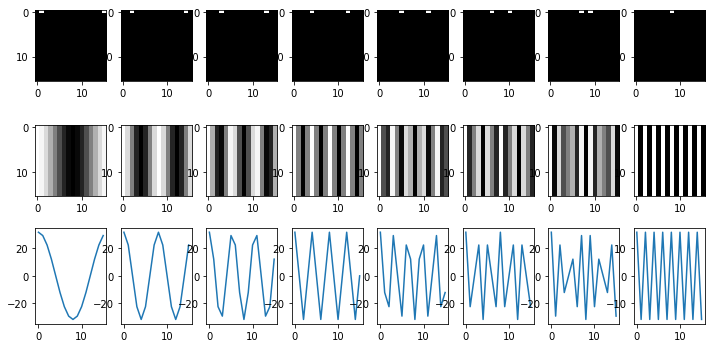

In [32]:
num=8
plt.figure(figsize=(12,6))
for i in range(num):
    fft_y=np.zeros((16,16),dtype=int)
    fft_y[0,i+1]=4080
    fft_y[0,15-i]=4080
    f=np.fft.ifft2(fft_y)
    plt.subplot(3,num,i+1)
    plt.imshow(fft_y,'gray')
    plt.subplot(3,num,i+num+1)
    plt.imshow(f.real,'gray')
    plt.subplot(3,num,i+2*num+1)
    plt.plot(np.linspace(0,15,16),f[0,:].real)

### 线

下图显示了使用不同频率的正弦波对原图进行恢复的过程。由于$F(0,0)=0$，缺少直流分量，恢复得到的原图$f(x=0)=239$，$f(x\neq 0)=-16$。缺少的直流分量$F(0,0)=16*256=4080$。由图可见，当在频谱中滤除高频分量，图片会变模糊，效果是图中锐利的边缘变弱，原本没边缘的地方有了边缘，清晰度下降。但是我们通常不会通过加上高频信号来使模糊图像变清晰。

高频由灰度的尖锐过渡造成，这一点在图中体现明显。

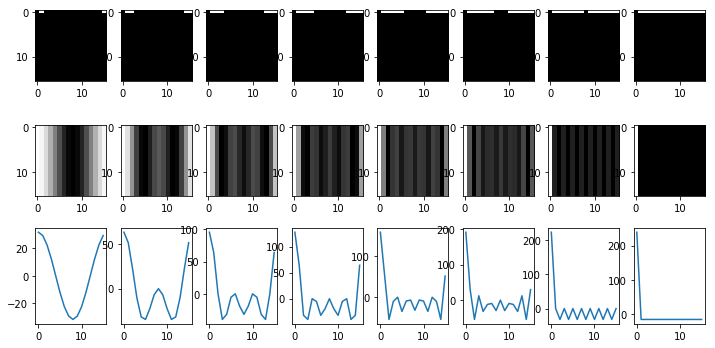

In [33]:
num=8
fft_y=np.zeros((16,16),dtype=int)
plt.figure(figsize=(12,6))
for i in range(num):
    fft_y[0,i+1]=4080
    fft_y[0,15-i]=4080
    f=np.fft.ifft2(fft_y)
    plt.subplot(3,num,i+1)
    plt.imshow(fft_y,'gray')
    plt.subplot(3,num,i+num+1)
    plt.imshow(f.real,'gray')
    plt.subplot(3,num,i+2*num+1)
    plt.plot(np.linspace(0,15,16),f[0,:].real)

In [34]:
f[0,:].real

array([239.0625, -15.9375, -15.9375, -15.9375, -15.9375, -15.9375,
       -15.9375, -15.9375, -15.9375, -15.9375, -15.9375, -15.9375,
       -15.9375, -15.9375, -15.9375, -15.9375])

### 圆

时域是圆，频域还是圆。可以将输入理解为无数条线段的叠加，频谱是无数个sinc函数的叠加。

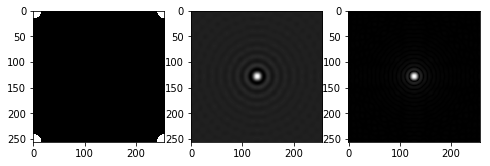

In [35]:
f=np.zeros((256,256),dtype=int)
rr,cc=draw.circle(128,128,16)
draw.set_color(f,[rr,cc],255)
f=np.fft.fftshift(f)
show_dft(f)

圆环的频谱如下图所示。由傅里叶变换的对称性，圆的频谱是圆，频谱是圆时域还是圆。但是与圆形相比，高频部分出现了明显的干扰波纹，而且强度明显，与单位脉冲函数的频谱有些相似，能量分布在整个频域。

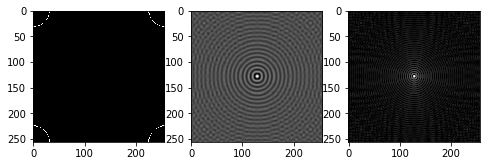

In [36]:
f=np.zeros((256,256),dtype=int)
rr,cc=draw.circle_perimeter(128,128,32)
draw.set_color(f,[rr,cc],255)
f=np.fft.fftshift(f)
show_dft(f)

### 纹理

#### 一维条纹

一维纹理指的是在某一方向上完全没有变化的纹理，它的频谱图是一条过原点的直线，方向与条纹方向垂直。1种情况下这条直线上除原点只有截止频率处的1个点;特殊情况下这条直线上有2个及以上共轭对称的点，其中某些点不相邻;一般情况下这条直线上每个点都有值。

当条纹的间隔较窄时，对应频谱高频区的亮点，能量集中在高频区；当条纹间隔较宽时，能量分散开来，在某些距离上会呈现规律的独立亮点；当条纹间隔无穷大，能量分布在整个频域。各个条纹可以叠加，叠加之后的频谱依旧是一条直线，位于垂直频率为0处。

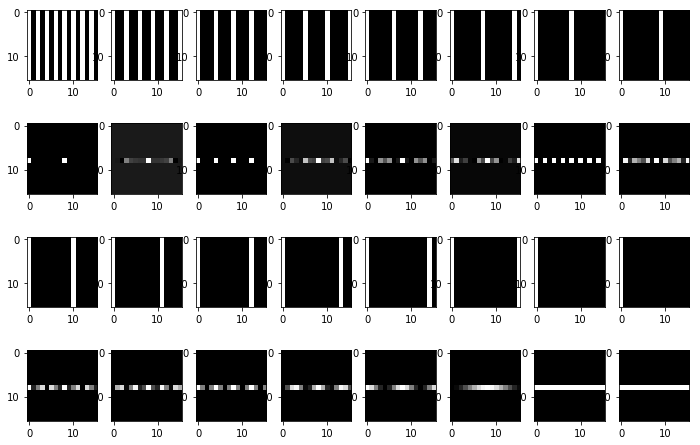

In [37]:
plt.figure(figsize=(24,8))

num=16
fft_y=np.zeros((16,16),dtype=int)
for i in range(num):
    f=np.zeros((16,16),dtype=int)
    f[:,np.arange(0,16,i+2)]=256
    fft_y=np.fft.fft2(f)
    fft_y=np.fft.fftshift(fft_y)
    if i>7:
        offset=2*num-8
    else:
        offset=0
    plt.subplot(4,num,i+1+offset)
    plt.imshow(f,'gray')
    plt.subplot(4,num,num+i+1+offset)
    plt.imshow(fft_y.real,'gray')

给纹理垂直方向上加个门函数，可以看到频谱的垂直方向上出现了sinc函数的变化趋势，最后一张图表现最清楚。

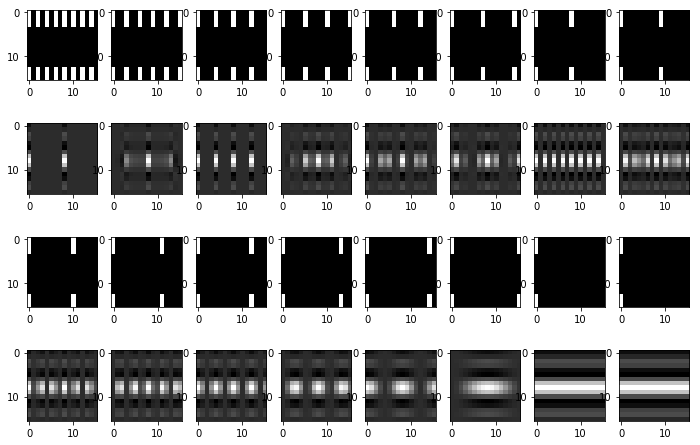

In [38]:
plt.figure(figsize=(24,8))

num=16
fft_y=np.zeros((16,16),dtype=int)
for i in range(num):
    f=np.zeros((16,16),dtype=int)
    f[0:4,np.arange(0,16,i+2)]=256
    f[13:16,np.arange(0,16,i+2)]=256
    fft_y=np.fft.fft2(f)
    fft_y=np.fft.fftshift(fft_y)
    if i>7:
        offset=2*num-8
    else:
        offset=0
    plt.subplot(4,num,i+1+offset)
    plt.imshow(f,'gray')
    plt.subplot(4,num,num+i+1+offset)
    plt.imshow(fft_y.real,'gray')

如果加的是原点一左一右对称的两个门函数，效果依旧是原本频谱是一条直线，现在在垂直方向上散开。可以看出频谱在垂直方向上的变化与上例略有不同，但是不同的仅仅是相角，幅值是不变的。由于显示的仅仅是实部，某些地方由正变负，显示上的原因导致看起来高频区能量更强。这个例子说明了做傅里叶变换时，原点的选择并不重要，平移不改变图像的幅值谱，仅仅改变相位。

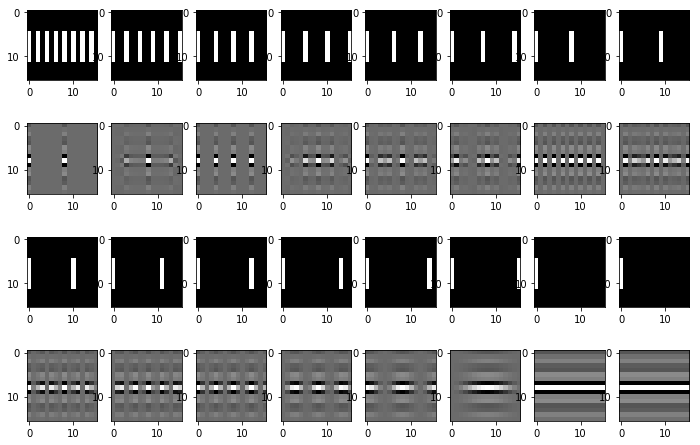

In [39]:
plt.figure(figsize=(24,8))

num=16
for i in range(num):
    f=np.zeros((16,16),dtype=int)
    f[5:12,np.arange(0,16,i+2)]=256
    fft_y2=np.fft.fft2(f)
    fft_y2=np.fft.fftshift(fft_y2)
    if i>7:
        offset=2*num-8
    else:
        offset=0
    plt.subplot(4,num,i+1+offset)
    plt.imshow(f,'gray')
    plt.subplot(4,num,num+i+1+offset)
    plt.imshow(fft_y2.real,'gray')

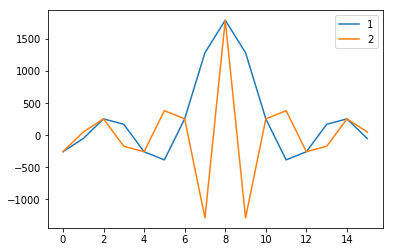

In [40]:
plt.plot(np.linspace(0,15,16),fft_y[:,0].real,label='1')
plt.plot(np.linspace(0,15,16),fft_y2[:,0].real,label='2')
plt.legend()

In [41]:
np.sum(np.abs(fft_y[:,0].real)==np.abs(fft_y2[:,0].real))==16

True

给纹理水平方向上加个门函数并平移到合适位置后，做傅里叶变换，可以看到频谱的水平方向上出现了扩散。

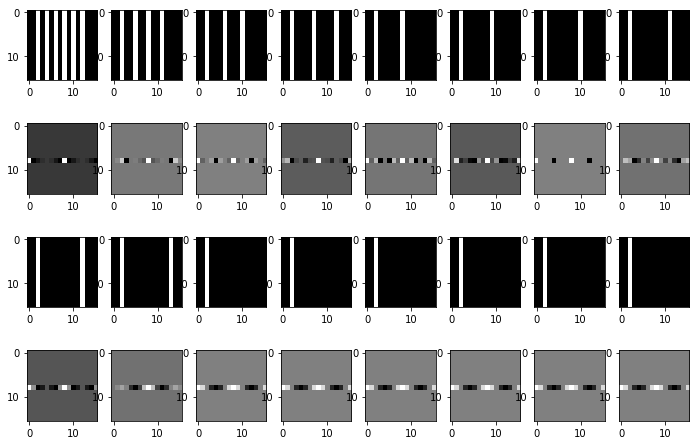

In [42]:
plt.figure(figsize=(24,8))

num=16
fft_y=np.zeros((16,16),dtype=int)
for i in range(num):
    f=np.zeros((16,16),dtype=int)
    f[:,np.arange(2,14,i+2)]=256
    fft_y=np.fft.fft2(f)
    fft_y=np.fft.fftshift(fft_y)
    if i>7:
        offset=2*num-8
    else:
        offset=0
    plt.subplot(4,num,i+1+offset)
    plt.imshow(f,'gray')
    plt.subplot(4,num,num+i+1+offset)
    plt.imshow(fft_y.real,'gray')

水平和垂直方向上都有门限信号。此时水平和垂直方向都有*频率泄露*，但是幅值谱上原来的亮点依旧清晰可辨。如果想消除纹理，可将这些亮点及邻域置0，但是想完全消除还是比较困难。尤其是过主要亮点的垂直线上的次亮点，不破坏目标区域的情况下也应该消除。

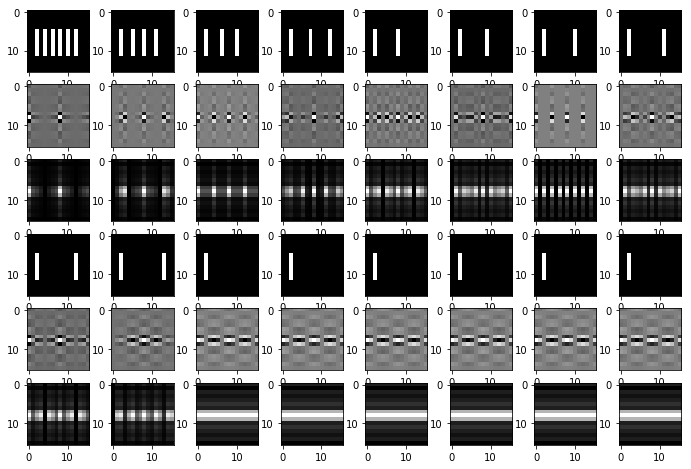

In [43]:
plt.figure(figsize=(24,8))

num=16
fft_y=np.zeros((16,16),dtype=int)
for i in range(num):
    f=np.zeros((16,16),dtype=int)
    f[5:12,np.arange(2,14,i+2)]=256
    fft_y=np.fft.fft2(f)
    fft_y=np.fft.fftshift(fft_y)
    
    if i>7:
        offset=3*num-8
    else:
        offset=0
    plt.subplot(6,num,i+1+offset)
    plt.imshow(f,'gray')
    plt.subplot(6,num,num+i+1+offset)
    plt.imshow(fft_y.real,'gray')
    plt.subplot(6,num,2*num+i+1+offset)
    plt.imshow(np.abs(fft_y),'gray')

#### 二维纹理

将二维纹理看做两个或多个一维条纹的叠加。下图展现了由横向和纵向最大频率的余弦波构成的一亮一暗条纹,叠加得到的图片，频谱即为两个一维条纹频谱的叠加。

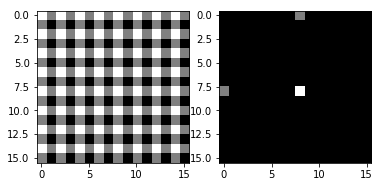

In [44]:
f=np.zeros((16,16),dtype=int)
tmp=np.zeros((16,16),dtype=int)
f[:,np.arange(0,16,2)]=127
tmp[np.arange(0,16,2),:]=127
f=f+tmp
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
plt.subplot(1,2,1)
plt.imshow(f,'gray')
plt.subplot(1,2,2)
plt.imshow(fft_y.real,'gray')

当纹理在图中有限，频谱中每个点都不为0，幅值谱上依旧可以找到三个亮点。原点处的亮点对应图片均值，左侧点对应水平方向余弦，上方点对应垂直方向余弦。在频域可以方便地去除原图中的水平或垂直纹理，这是使用傅里叶变换的原因。

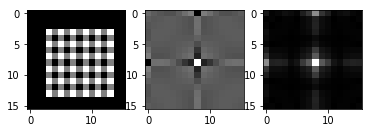

In [45]:
f=np.zeros((16,16),dtype=int)
tmp=np.zeros((16,16),dtype=int)
f[3:14,np.arange(3,15,2)]=127
tmp[np.arange(3,15,2),3:14,]=127
f=f+tmp
fft_y=np.fft.fft2(f)
fft_y=np.fft.fftshift(fft_y)
plt.subplot(1,3,1)
plt.imshow(f,'gray')
plt.subplot(1,3,2)
plt.imshow(fft_y.real,'gray')
plt.subplot(1,3,3)
plt.imshow(np.abs(fft_y),'gray')

对于水平和竖直方向条纹相乘的情况，如下图所示。由于余弦信号的相乘，图中的均值差不多降到0，频谱中的直流分量不明显了，过原点的竖线被分散到垂直轴两侧。数学描述上，时域的点乘对应频域的卷积，所谓卷积就是一张频谱旋转180°，依次滑过另一张频谱的每个像素，在每个滑动窗口内做相关运算。与前一张垂直和水平方向正弦波相加的频谱相比，相乘频谱上点的平移对应相加原图各点乘以$2\pi(\frac{u_{0}}{W}x+\frac{v_0}{H}y)$，当原图是实数时，体现在原图上的就是一条线上某些点被置0，某些点乘了-1，某些点保持不变。比较图片时需注意，当图中有负灰度值时，0灰度被显示成灰色而不是黑色。顺便一提的是，实数图转到频域，再从频域转回来，理论上是一模一样，但在实际计算过程中，计算机计算精度有限，存在舍入误差和寄生复数项，一般直接取实部复原原图。

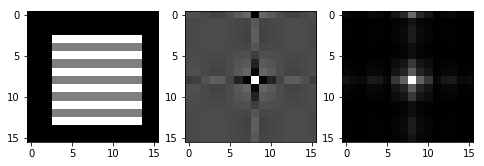

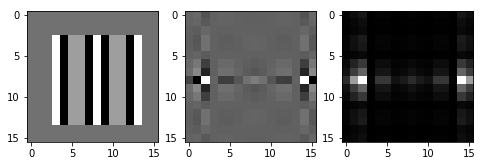

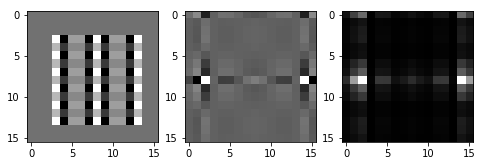

In [46]:
f=np.zeros((16,16),dtype=int)
f[np.arange(3,15,2),3:14]=255
f[np.arange(4,14,2),3:14]=127
f_hor=np.cos(8*np.pi*np.arange(0,11)/10)
f_hor=np.tile(f_hor,[11,1])
f_hor=np.pad(f_hor,([3,2],[3,2]),'constant',constant_values=0)
f_multi=f*f_hor
show_dft(f)
show_dft(f_hor)
show_dft(f_multi)

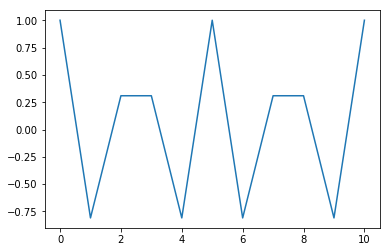

In [47]:
plt.plot(np.arange(0,11),f_hor[3,3:14])

对于水平和斜向条纹相乘的情况，当条纹旋转时，频谱也对应旋转，之后再和水平条纹的频谱做卷积。图(1)与图(2)卷积，就是在图(1)的每个位置复制旋转180°后的图(2)。卷积之后频域的旋转与时域的旋转依旧保持一致。下图中纹理旋转了30°，但是由于像素精度的原因，并未得到一条30°的完美直线，对应的频谱上的差不多直线也差不多跟纹理旋转了同样的角度，差不多呈垂直。而在频域卷积得到的幅值谱上，既可以看到十字，也可以看到斜线。

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  


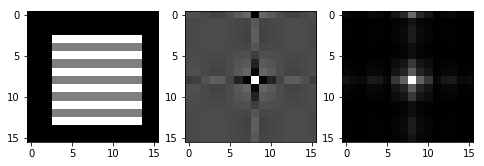

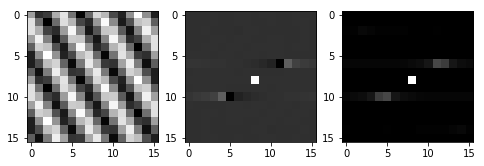

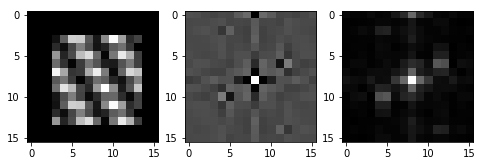

In [48]:
f=np.zeros((16,16),dtype=int)
f[np.arange(3,15,2),3:14]=255
f[np.arange(4,14,2),3:14]=127
f_hor=np.cos(16*np.pi*np.arange(0,32)/32)
f_hor=np.tile(f_hor,[32,1])
f_hor=misc.imrotate(f_hor,angle=30)
f_hor=f_hor[8:24,8:24]
f_multi=f*f_hor
show_dft(f)
show_dft(f_hor)
show_dft(f_multi)

### 傅里叶变换的应用

### 滤波

为了保持空间滤波与频域滤波的一致性，将空间滤波转到频域滤波之前，首先对图像和旋转后的滤波器模板**补零**，将宽度均补到**$M_1+M_2-1$**，长度均补到**$N_1+N_2-1$**，$M_1,M_2$分别为图片和滤波器宽度，$N_1,N_2-1$分别为图片和滤波器长度。之后再做傅里叶变换，频域点乘，反变换，通过裁切得结果。否则会导致缠绕错误。

理解缠绕错误的关键在于牢记在心，傅里叶变换的输入和输出都是定义在$(-\infty,+\infty)$上的周期函数。

需要区分时域的卷积与相关运算，二者隔了滤波器旋转180°。

高斯滤波器的频域表示
$$
H(u)=Ae^{-\frac{u^2}{2\sigma^2}}
$$
高斯滤波器的时域表示
$$
h(x)=\sqrt{2\pi} \sigma Ae^{-2 \pi^2 \sigma^2 x^2}
$$
形状一样，但是一个越宽，一个越窄。$\sigma$取无穷大或无穷小时，一个对应常数，一个对应单位脉冲函数。当我们选择高斯滤波器时，一定了解清楚$\sigma$是分子还是分母，是频域滤波器还是时域滤波器。

使用空间滤波器需要对滤波器和原图进行填充，与直接指定频域滤波器相比，有哪些优势和劣势？实际应用中如何选择？频域滤波器对应于空间域哪个滤波器的卷积运算？

### FFT实现

#### 对输入图片大小有要求:2的整数次幂

HALCON中为什么傅里叶正变换和反变换都是一个函数fft_generic()?

因为二维离散傅里叶反变换也可以通过正变换公式得到。证明如下。
$$
f(x,y) =\frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(\frac{u}{M},\frac{v}{N})e^{j2\pi \frac{u}{M}x+\frac{v}{N}y}
$$
等式两边取共轭：
$$
f^*(x,y) =\frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F^*(\frac{u}{M},\frac{v}{N})e^{-j2\pi \frac{u}{M}x+\frac{v}{N}y}
$$
由于$f(x,y)$是实数，因此：
$$
f(x,y) =\frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F^*(\frac{u}{M},\frac{v}{N})e^{-j2\pi \frac{u}{M}x+\frac{v}{N}y}
$$
即将$F^*(\frac{u}{M},\frac{v}{N})$输入到已有正向算法中，将得到$MNf(x,y)$。